# nema3 PDE=0.3, sigmaT = 50 ps, SiPMs 40 mm phot qc =2 pes 

- Phantom : nema 3
- Events: phot
- Detector geometry: SiPMs in LXe, with naked sipms
- Time resolution: 50 ps
- qcut > 2 pes
- ntof > 7
- PDE = 0.3
- LXe = 40 mm

In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment in ,,/src

In [2]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [3]:
using Glob
using CSV

In [4]:
using Statistics
using StatsBase
using Printf

In [5]:
using Logging

In [6]:
using ATools

┌ Info: Precompiling ATools [f146b9ee-cb39-4cb9-873f-768aeedb20d7]
└ @ Base loading.jl:1317


In [7]:
include("../src/ANema.jl") 

Main.ANema

In [8]:
println(names(ATools))

[:ATools, :centers, :dxyz, :edges, :find_max_xy, :fit, :fit_gauss, :fit_gauss_fm, :fit_pol1, :fit_pol2, :fit_pol3, :fit_profile, :fitg1, :fitg2, :fphi, :hist1d, :hist2d, :in_range, :mean_std, :p1df, :phixy, :rxy, :select_by_column_value, :select_by_column_value_closed_interval, :select_by_column_value_closed_left_interval, :select_by_column_value_closed_right_interval, :select_by_column_value_ge, :select_by_column_value_gt, :select_by_column_value_interval, :select_by_column_value_le, :select_by_column_value_lt, :select_by_index, :select_event, :wstd]


In [9]:
println(names(ANema))

[:ANema, :cdoi, :crt, :ctsr, :deltatime, :dftolor, :radial_correcction, :readdf, :selectinterval, :setunits, :write_lors_hdf5, :writemdf]


In [10]:
import Unitful:
    nm, μm, mm, cm, ns, μs, ms, ps, s

In [11]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

## NB functions
- These are specific for plotting and are better kept in the NB

In [12]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

# Notebook

In [13]:
norm = 5.0e+6 #    number of events generated for this run 
dir = "../data/"
dirp = "../plots"
conf = "n3-w-40mm-phot-qc2"
out = "n3mf-w-40mm-phot-qc2"
path = joinpath(dir, conf)
pathp = joinpath(dirp, conf)
patho = joinpath(dir, out)

if isdir(pathp) == false
    mkdir(pathp)
end

if isdir(patho) == false
    mkdir(patho)
end
println("input dir ", path)
println("plots in ", pathp)
println("merged DF in ", patho)

input dir ../data/n3-w-40mm-phot-qc2
plots in ../plots/n3-w-40mm-phot-qc2
merged DF in ../data/n3mf-w-40mm-phot-qc2


In [14]:
ndf = ANema.readdf(path) 
println("data frame has length of ", nrow(ndf))
println("data frame names ", names(ndf))

data frame has length of 58945
data frame names ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

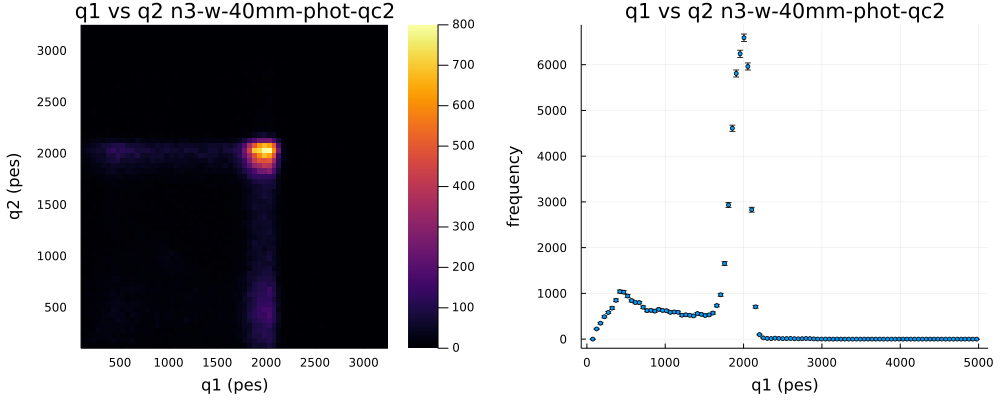

In [15]:
ANema.q1vsq2(ndf, tit="q1 vs q2 $conf", filename=joinpath(pathp, "q1q2"), save=true)

In [16]:
@printf "fraction of events with 2 pe = %5.2g" nrow(ndf) / norm

fraction of events with 2 pe = 0.012

## Cut in (q1,q2) 

In [17]:
ndfq =ANema.selectinterval(ndf, "q1", "q2", 1700.0, 2200.0);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq))
println("fraction of events ", nrow(ndfq) / norm)

after q1q2 cut: ndfq has a length of 21896
fraction of events 0.0043792


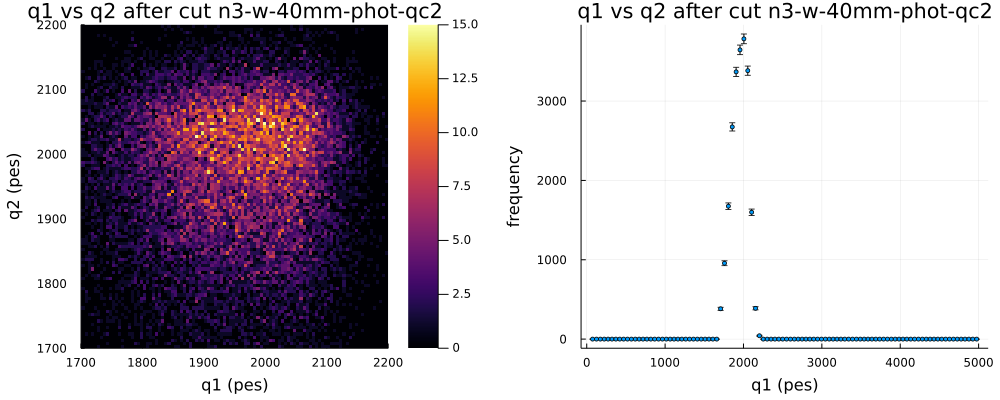

In [18]:
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $conf", 
filename=joinpath(pathp, "q1q2-qcut"), save=true)

## r vs q

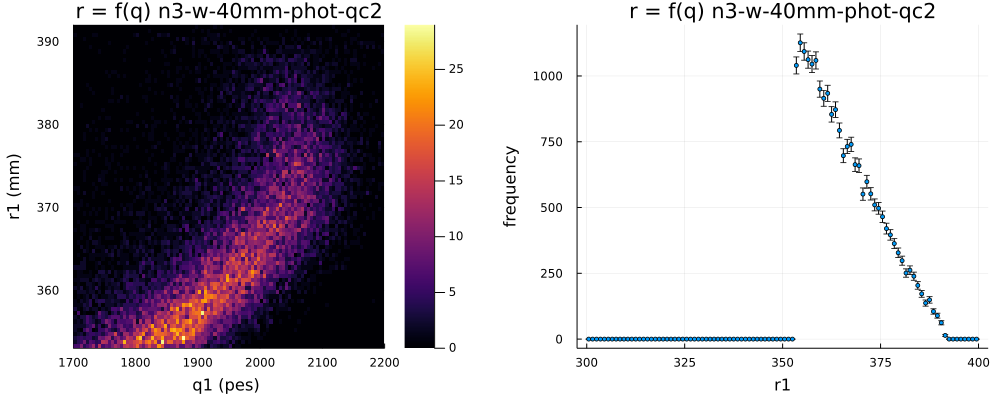

In [19]:
ANema.r1q1(ndfq,tit="r = f(q) $conf", filename=joinpath(pathp, "rq"), save=true)

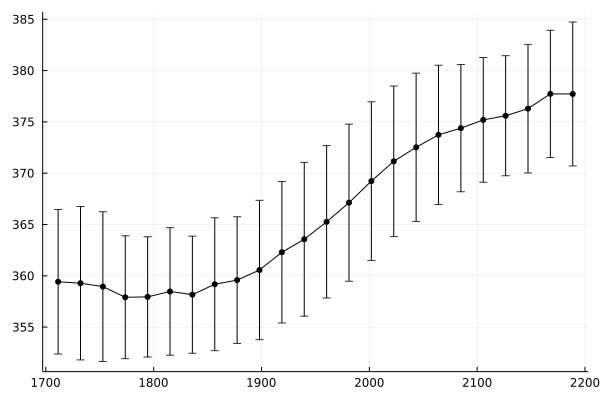

In [20]:
dfp, p1 = p1df(ndfq.q1, ndfq.r1, 25)
plot(p1)

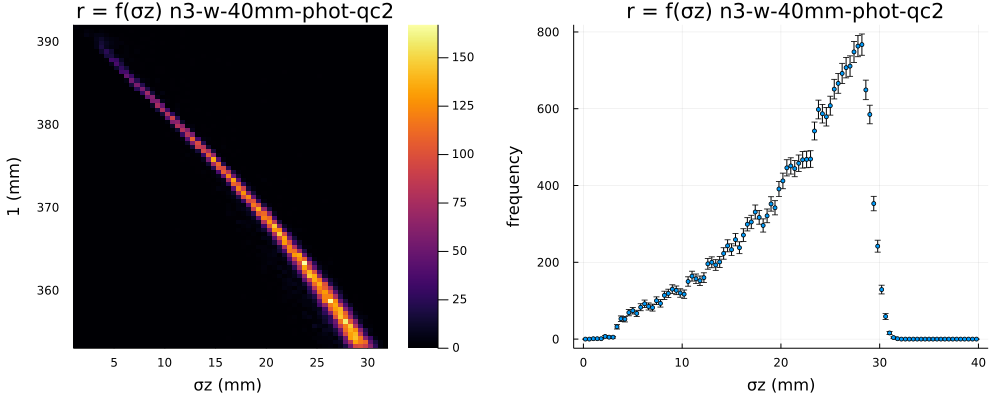

In [23]:
ANema.zstd(ndfq, tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

In [21]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 1.0, 30.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))

after zstd cut: ndfz has a length of 21595


Fit parameters: a = 395.0 b =  -1.4 Fit errors: a =   0.3 b =  0.02 

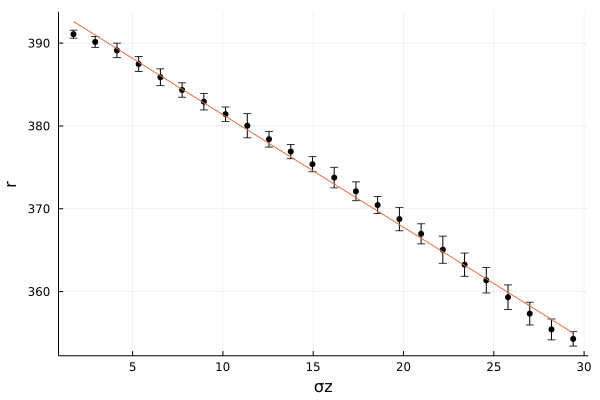

In [22]:
fz1, pz1 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol1")
fpars = fz1.fitpar
fstds = fz1.fitstd
@printf "Fit parameters: a = %5.1f b = %5.1f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.1g " fstds[1] fstds[2]
plot(pz1)

Fit parameters: a = 393.19 b = -1.04 c = -0.01 Fit errors: a =   0.2 b = 0.022 c = 0.0007

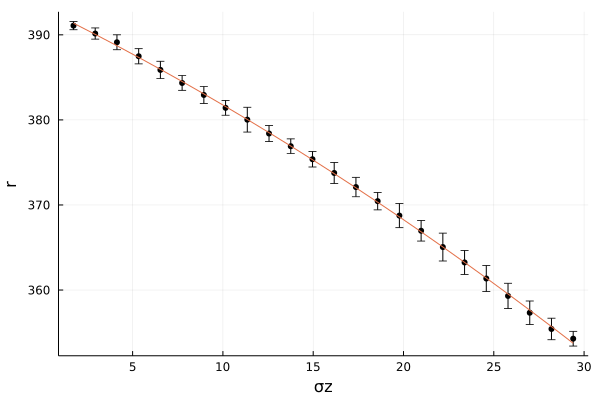

In [23]:
fz2, pz2 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pz2, joinpath(pathp, "zstd-fitpol2"))
plot(pz2)

Fit parameters: a = 393.14 b = -1.02 c = -0.012 d = 3.1e-05 Fit errors: a =   0.2 b = 0.064 c = 0.0047 c = 9.8e-05

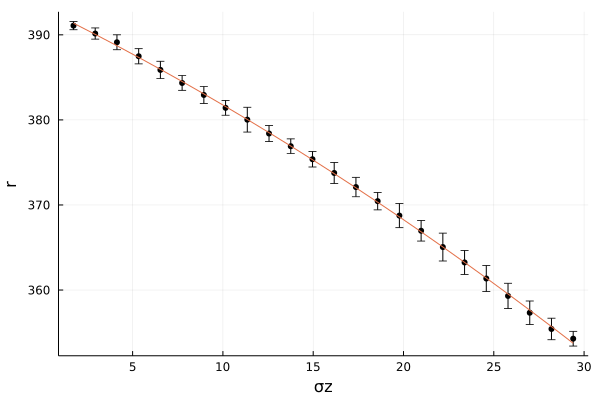

In [24]:
fz3, pz3 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol3")
fpars = fz3.fitpar
fstds = fz3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g d = %5.2g " fpars[1] fpars[2] fpars[3] fpars[4]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3] fstds[4]
plot(pz2)

Fit parameters: a = 393.19 b = -1.04 c = -0.01 Fit errors: a =   0.2 b = 0.022 c = 0.0007

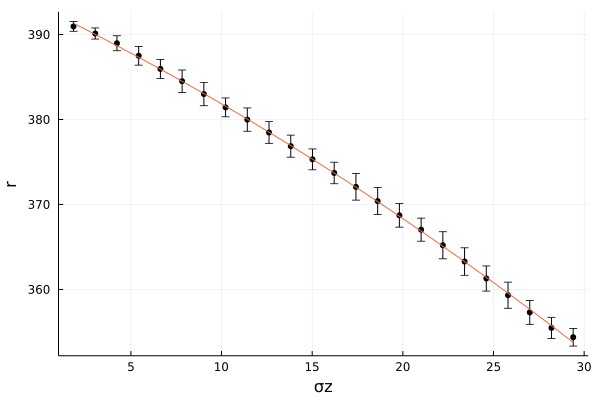

In [25]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

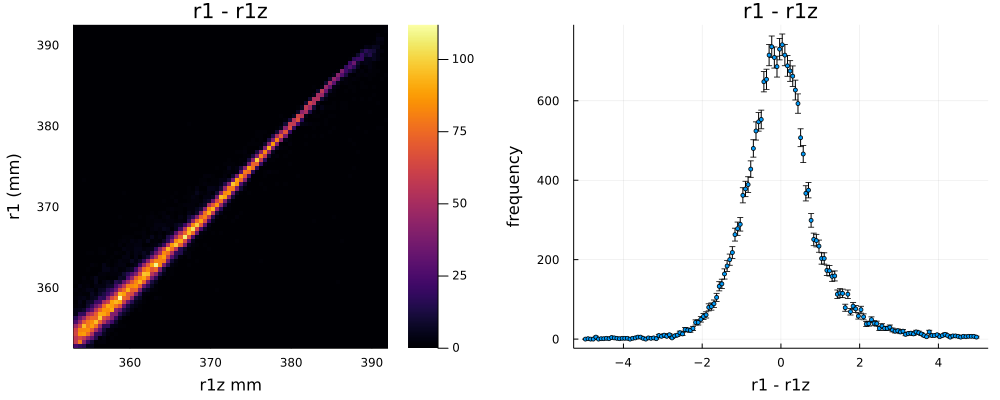

In [26]:
r1z = fz2.g.(ndfz.zstd1) + 0.0 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -5., 5.0, tit="r1 - r1z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


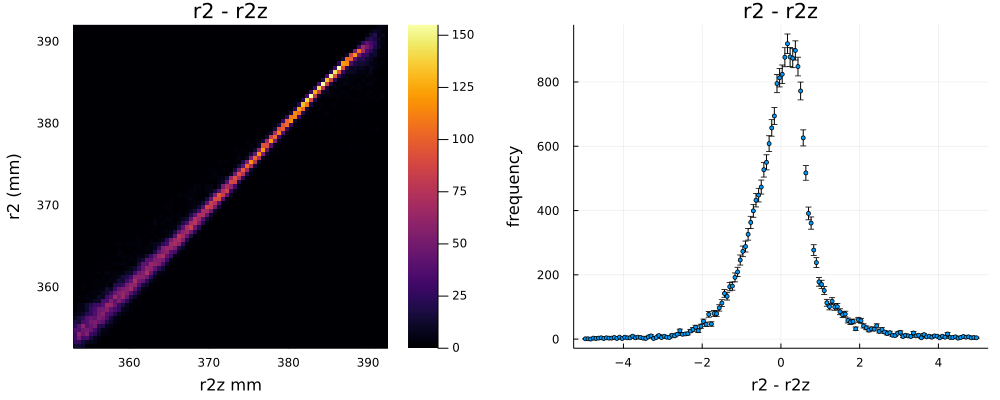

In [27]:
r2z = fzr2.g.(ndfz.zstd2) + 0.0 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -5., 5.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


 σ =     0.7 mm

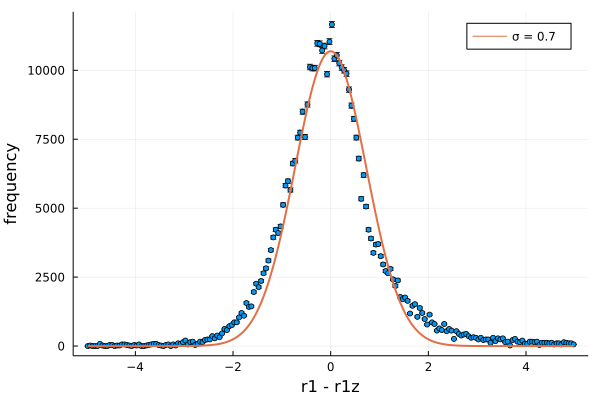

In [28]:
fg,p = fitg1(r1z - ndfz.r1, "r1 - r1z", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

r-rz σ1 =   1.095 σ2 =   0.506

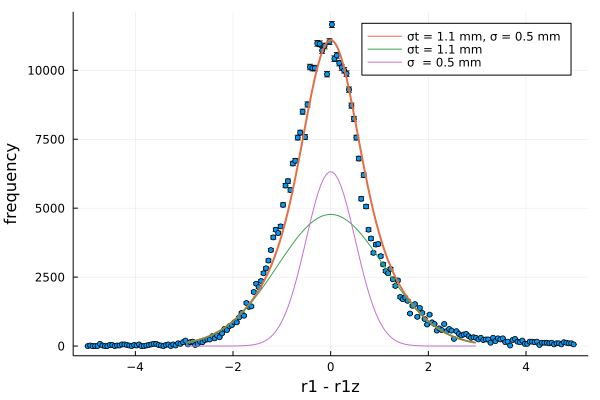

In [29]:
fg, p = fitg2(r1z - ndfz.r1, "r1 - r1z", 200, -5.0, 5.0, 
                      xg1min=-3.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-3.0, xgmax  =3.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2"))
plot(p)

 σ =     0.6 mm

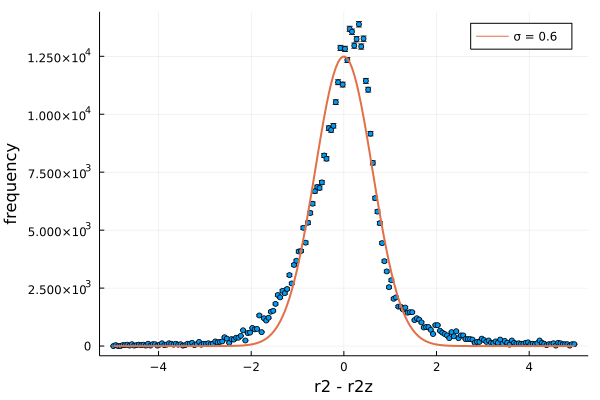

In [30]:
fg,p = fitg1(r2z - ndfz.r2, "r2 - r2z", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1-r2"))
plot(p)

## Phistd

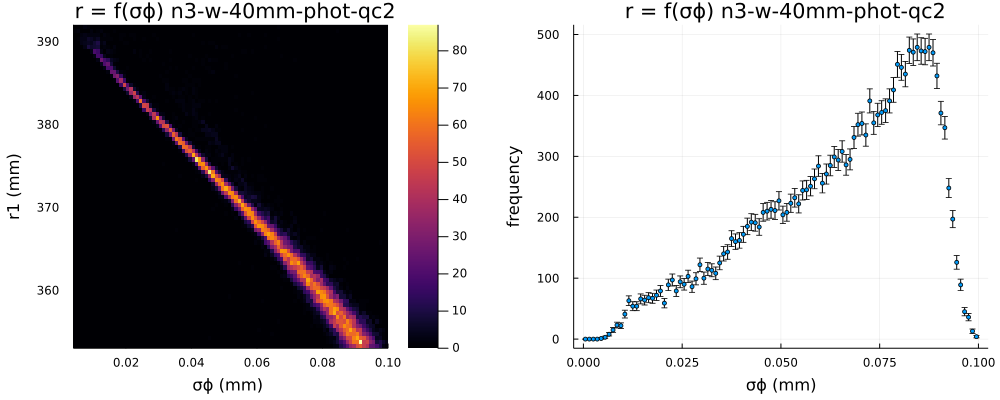

In [31]:
ANema.phistd(ndfq, tit=" r = f(σϕ) $conf", filename=joinpath(pathp, "phistd"), save=true)

In [43]:
ndfp =ANema.selectinterval(ndfq, "phistd1", "phistd2", 0.001, 0.095);
println("after pstd cut: ndfz has a length of ", nrow(ndfp))

after pstd cut: ndfz has a length of 18597


Fit parameters: a = 392.85 b = -386.54 c = -3.7e+02 Fit errors: a =   0.2 b =    10 c =    98

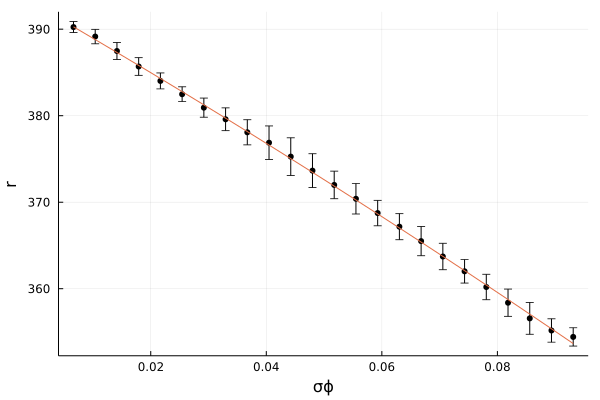

In [44]:
fp2, pp2 = fit_profile(ndfp.phistd1, ndfp.r1, "σϕ", "r", "pol2")
fpars = fp2.fitpar
fstds = fp2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pp2, joinpath(pathp, "phistd-fitpol2"))
plot(pp2)

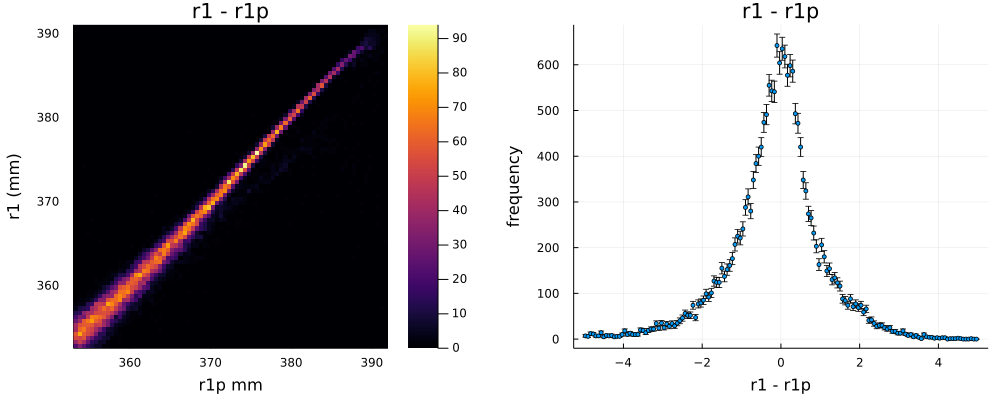

In [56]:
r1p = fp2.g.(ndfp.phistd1) - 0.25 * ones(length(ndfp.q1)) ; 
ANema.plotreso(r1p, ndfp.r1, "r1p mm", "r1 (mm)", -5., 5.0, tit="r1 - r1p", 
         filename=filename=joinpath(pathp, "r1-r1p"), save=true)


 σ =     0.7 mm

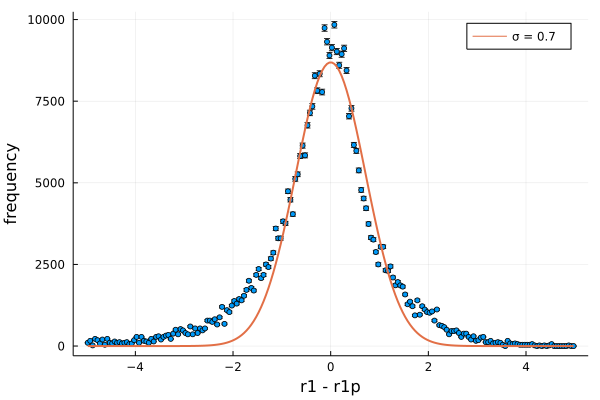

In [57]:
fg,p = fitg1(r1p - ndfp.r1, "r1 - r1p", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "phistd-fitg1"))
plot(p)

Fit parameters: a = 392.85 b = -386.54 c = -3.7e+02 Fit errors: a =   0.2 b =    10 c =    98

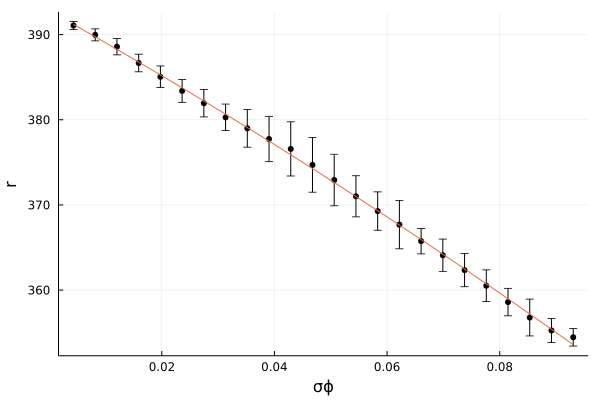

In [58]:
fpr2, ppr2 = fit_profile(ndfp.phistd2, ndfp.r2, "σϕ", "r", "pol2")
fpars = fp2.fitpar
fstds = fp2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(ppr2, joinpath(pathp, "phistd-fitpol2-r2"))
plot(ppr2)

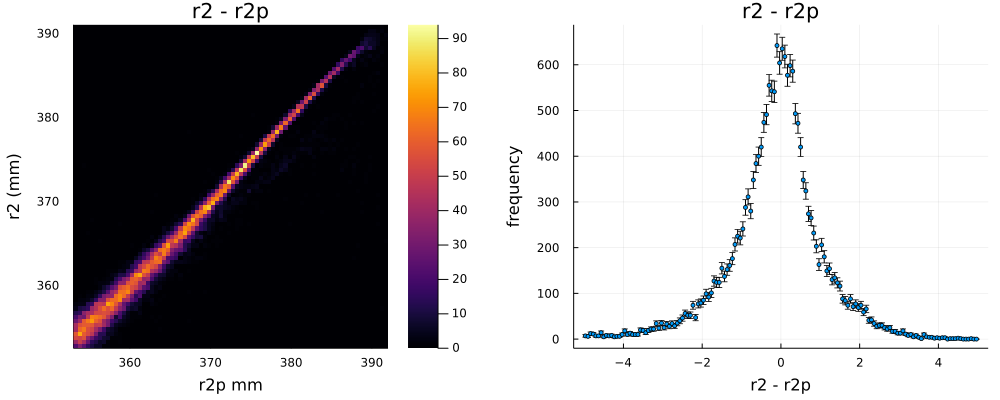

In [59]:
r2p = fpr2.g.(ndfp.phistd2) - 0.25 * ones(length(ndfp.q2)) ; 
ANema.plotreso(r1p, ndfp.r1, "r2p mm", "r2 (mm)", -5., 5.0, tit="r2 - r2p", 
         filename=filename=joinpath(pathp, "r2-r2p"), save=true)


 σ =     0.6 mm

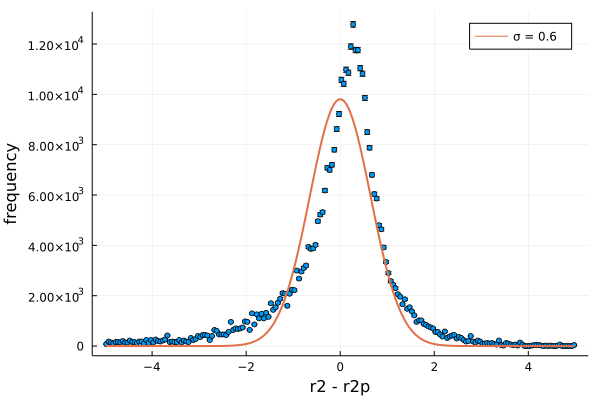

In [60]:
fg,p = fitg1(r2p - ndfp.r2, "r2 - r2p", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "phistd-fitg1"))
plot(p)

In [61]:
println("number of photoelectric events recorded ", nrow(ndf))
println("number of photoelectric events q ϵ (qmin, qmax) ", nrow(ndfq))
println("number of photoelectric events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))
println("number of photoelectric events phistd ϵ (phistd_min, phistd_max) ", nrow(ndfp))

number of photoelectric events recorded 58945
number of photoelectric events q ϵ (qmin, qmax) 21896
number of photoelectric events zstd ϵ (zstd_min, zstd_max) 21595
number of photoelectric events phistd ϵ (phistd_min, phistd_max) 18597


## Resolution in (x,y,z,r) intrinsic

 σx =     0.3 mm σy =     0.3 mm σz =     0.6 mm

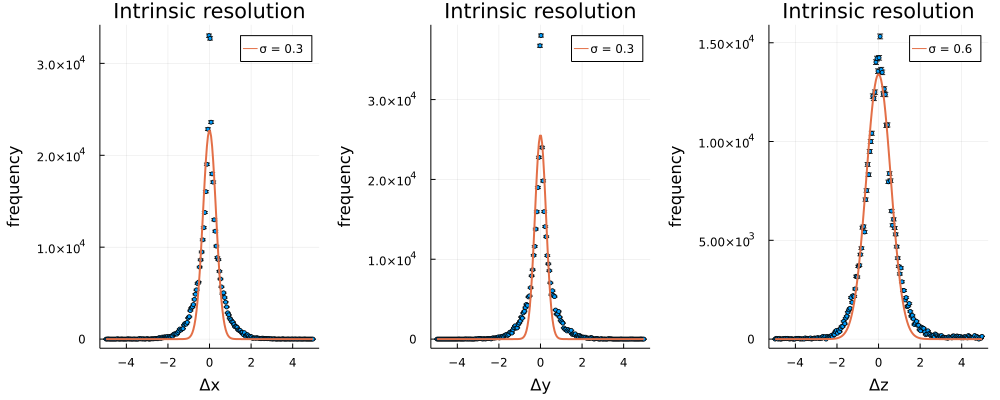

In [62]:
fg,px = fitg1(ndfz.xt1 - ndfz.x1, "Δx", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σx = %7.1f mm" fg.std[1]
fg,py = fitg1(ndfz.yt1 - ndfz.y1, "Δy", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σy = %7.1f mm" fg.std[1]
fg,pz = fitg1(ndfz.zt1 - ndfz.z1, "Δz", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σz = %7.1f mm" fg.std[1]
ANema.plot_and_save(px,py, pz, "Intrinsic resolution", joinpath(pathp, "Intrinsic-res")) 

## Resolución reco

## Position from best estimator (r1p)

In [63]:
xp1,yp1,zp1 = ANema.radial_correction(ndfp.xr1, ndfp.yr1, ndfp.zr1, r1p);
xp2,yp2,zp2 = ANema.radial_correction(ndfp.xr2, ndfp.yr2, ndfp.zr2, r2p);
xz1,yz1,zz1 = ANema.radial_correction(ndfz.xr1, ndfz.yr1, ndfz.zr1, r1z);
xz2,yz2,zz2 = ANema.radial_correction(ndfz.xr2, ndfz.yr2, ndfz.zr2, r2z);

In [64]:
fg,px1 = fitg1(ndfp.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py1 = fitg1(ndfp.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz1 = fitg1(ndfp.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1] 

 σx1 =  0.73 mm σy1 =  0.74 mm σz =  0.59 mm

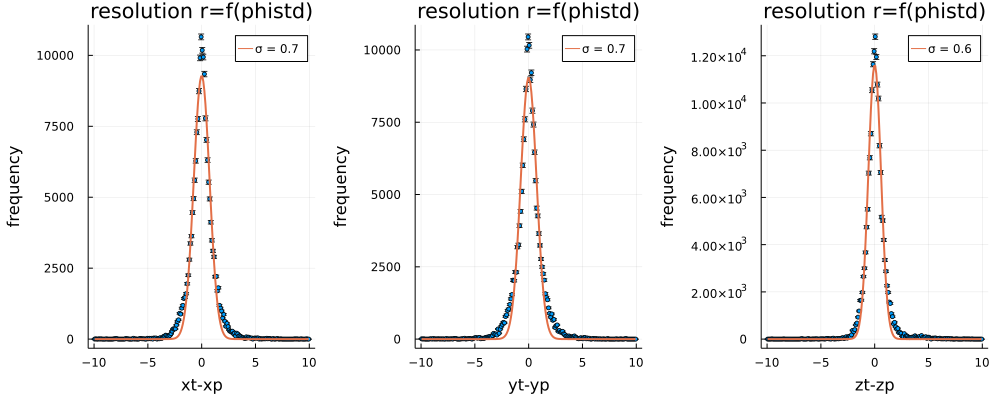

In [65]:
ANema.plot_and_save(px1,py1, pz1, "resolution r=f(phistd)", joinpath(pathp, "phistd-res")) 

 σx1 =  0.59 mm σy1 =  0.59 mm σz =  0.43 mm

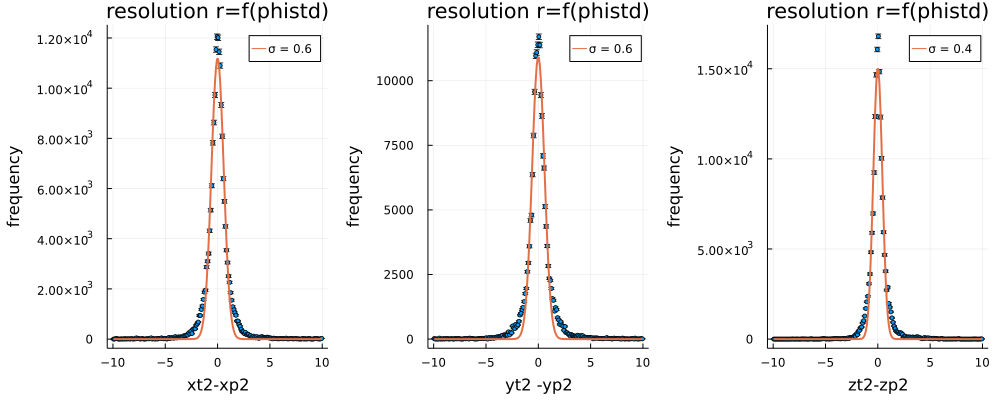

In [66]:
fg,px2 = fitg1(ndfp.xt2 - xp2, "xt2-xp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py2 = fitg1(ndfp.yt2 - yp2, "yt2 -yp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz2 = fitg1(ndfp.zt2 - zp2, "zt2-zp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(px2,py2, pz2, "resolution r=f(phistd)", joinpath(pathp, "phistd-res")) 

 σx1 =  0.73 mm σy1 =  0.72 mm σz =  0.60 mm

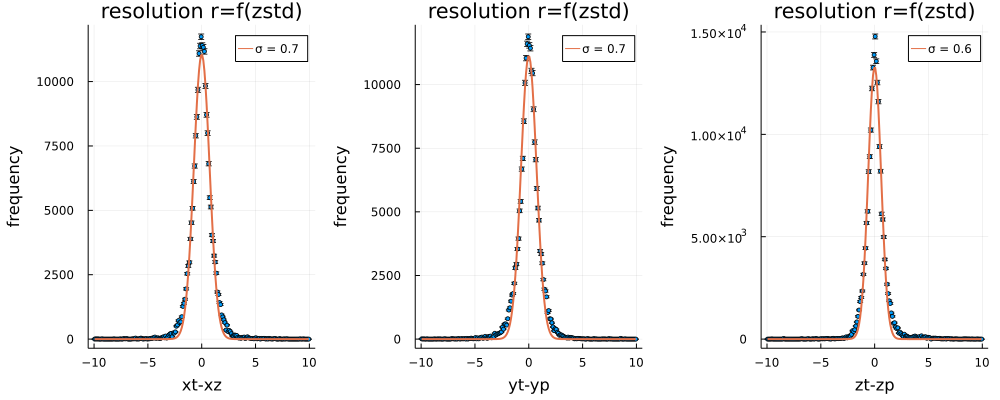

In [67]:
fg,pzx1 = fitg1(ndfz.xt1 - xz1, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy1 = fitg1(ndfz.yt1 - yz1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz1 = fitg1(ndfz.zt1 - zz1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx1,pzy1, pzz1, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r1")) 

 σx1 =  0.57 mm σy1 =  0.59 mm σz =  0.44 mm

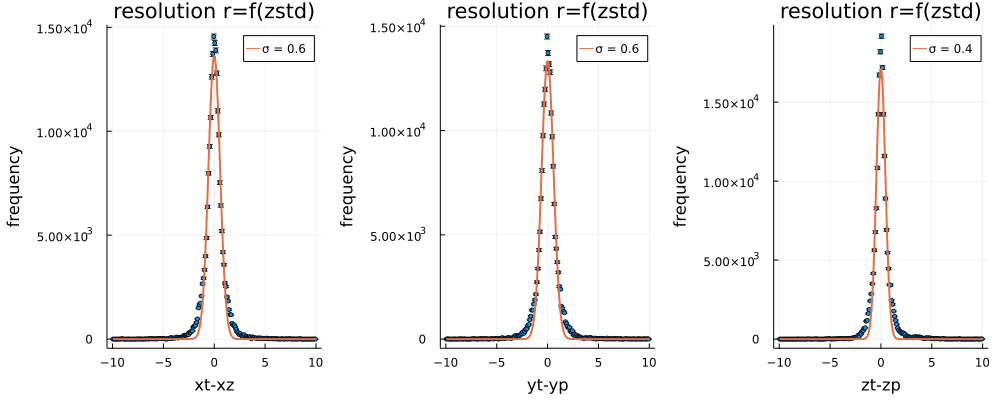

In [68]:
fg,pzx2 = fitg1(ndfz.xt2 - xz2, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy2 = fitg1(ndfz.yt2 - yz2, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz2 = fitg1(ndfz.zt2 - zz2, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx2,pzy2, pzz2, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r2")) 

## Summary: resolution in (X,Y,Z):
- Resolution in Z is very good, not affected by radial corrections.
- Resolution in (X,Y) depends on r estimator resolution, and is much worse for all events.

In [69]:
@printf "typical resolution (FWHM) = %5.2f" 2.3 * fg.std[1]

typical resolution (FWHM) =  1.01

In [70]:
ndfp[!,"r1x"] = r1p;
ndfp[!,"r2x"] = r2p;
ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

## TOF

In [71]:
dfp = ANema.setunits(ndfp);
dfz = ANema.setunits(ndfz);

In [72]:
dt12 = ANema.deltatime(dfp, ANema.dtfirst);

In [73]:
t12 = dt12./ps;
@printf " mean t12 = %5.2f std = %5.2f" mean(t12) std(t12)

 mean t12 = -19.37 std = 694.84

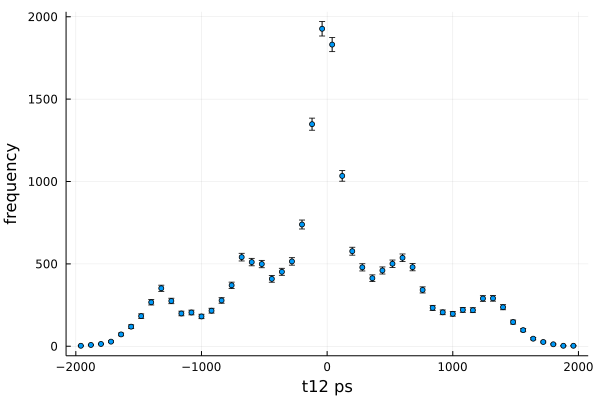

In [74]:
h,p       = hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(p)

 mean t12 = -42.50 std = 149.47

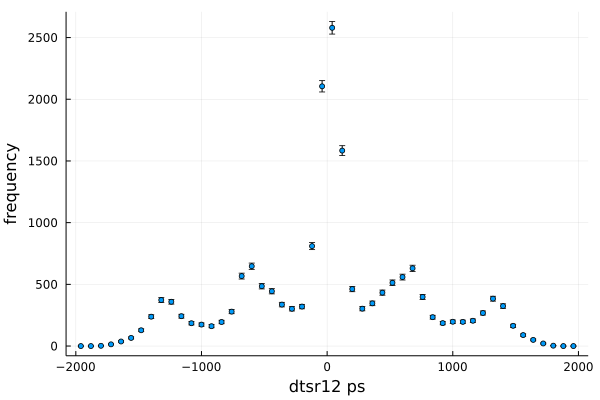

In [75]:
dtsr12 = ANema.ctsr(dfp, ANema.postrue)
tsr12 = dtsr12./ps
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12) std(t12 -tsr12)
h,p       = ANema.hist1d(tsr12, "dtsr12 ps", 50,  -2000., 2000.)
plot(p)

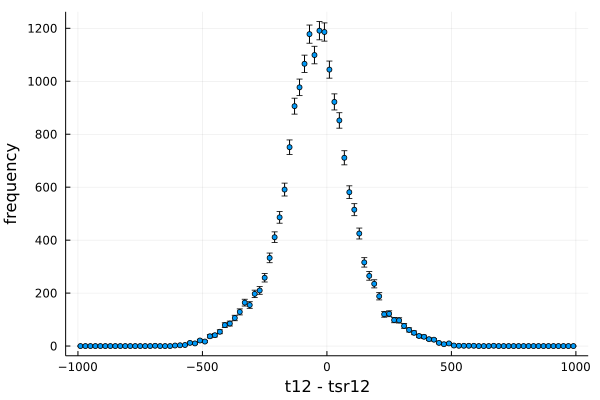

In [76]:
h,p       = hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
plot(p)

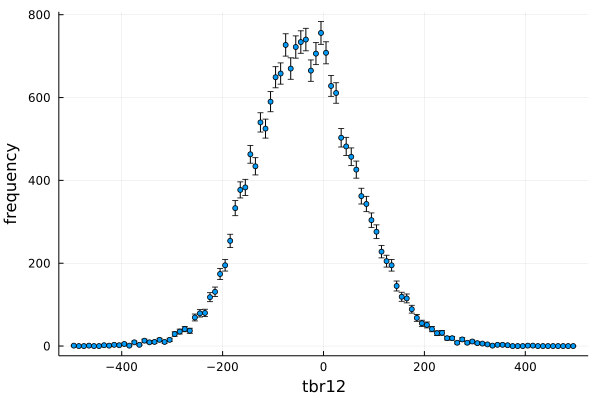

In [77]:
dtrb12 = ANema.cdoi(dfp,  ANema.postrue);
trb12  = dtrb12 ./ps
h,p    = hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(p)

 mean t12 = -6.40 std = 105.81

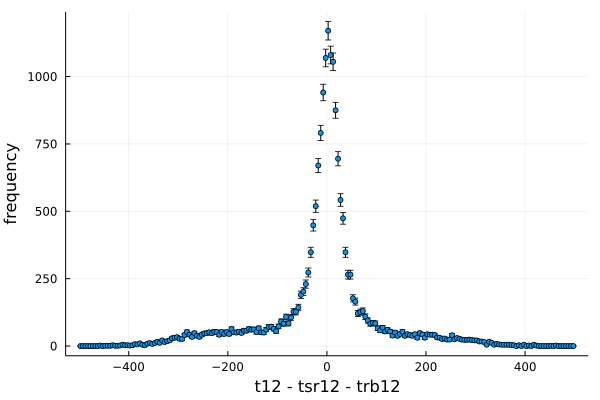

In [78]:
h,p       = hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 200,  -500., 500.)
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12 - trb12) std(t12 - tsr12 - trb12)
plot(p)

sigma1 = 155.828 sigma2 =  21.323

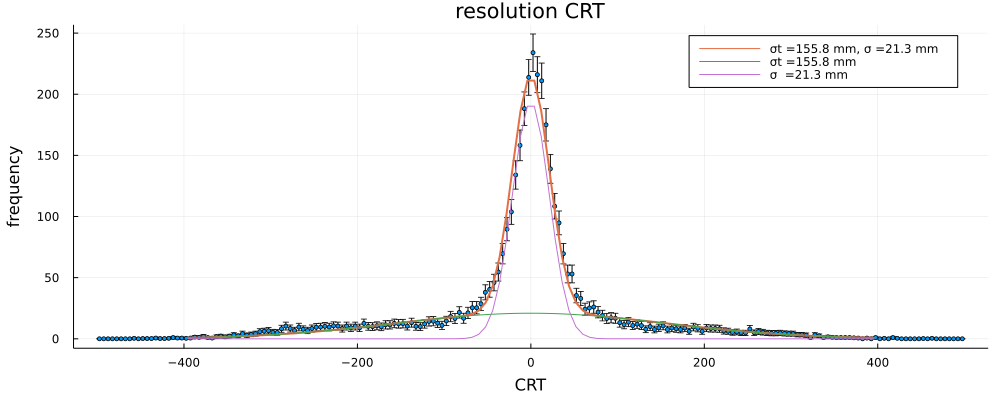

In [79]:
dt = t12 - tsr12 - trb12;
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(p, "resolution CRT", joinpath(pathp, "CRT")) 

First photon, position true: FWHM1 = 358.405 FWHM2 =  49.042

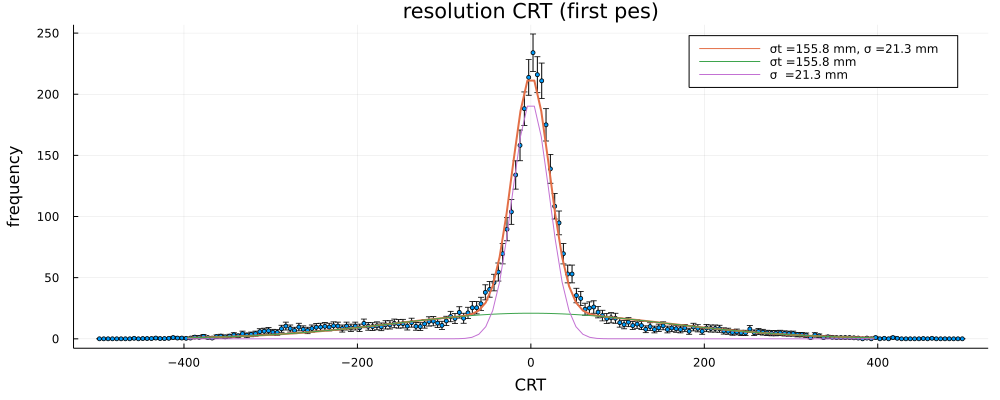

In [80]:
dt = ANema.crt(dfp, ANema.dtfirst,ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 190.833

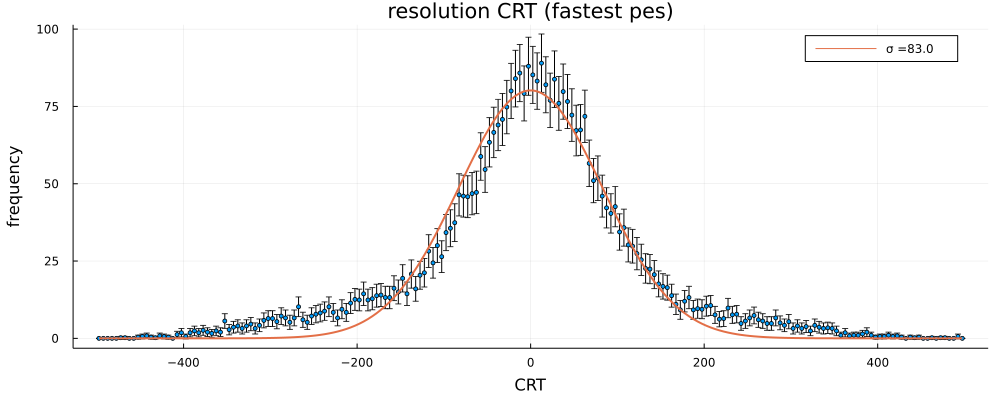

In [81]:
dt = ANema.crt(dfp,  ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 188.995

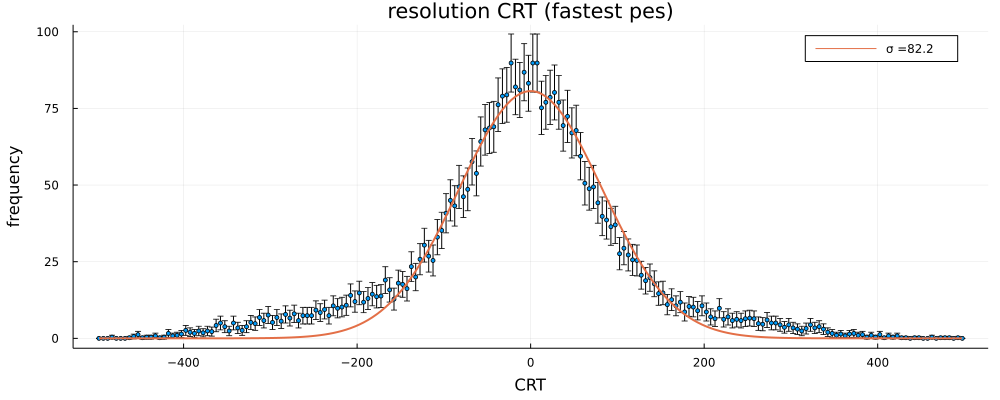

In [82]:
dt = ANema.crt(dfp, ANema.dtminimum,ANema.posreco)
fg,p = ANema.fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest-reco")) 

average photoelectron, position reco: FWHM = 294.822

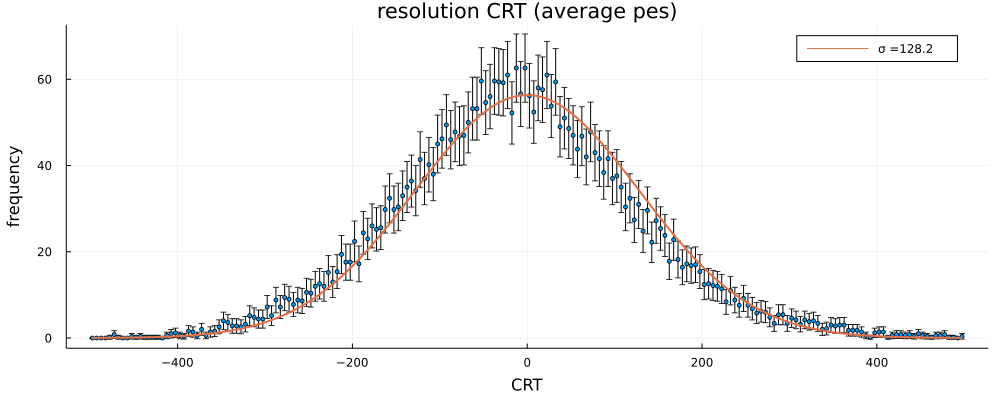

In [83]:
dt = ANema.crt(dfp, ANema.dtaverage,ANema.posreco)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes)", joinpath(pathp, "CRT-average-reco")) 

average photoelectron, position reco: FWHM = 295.562

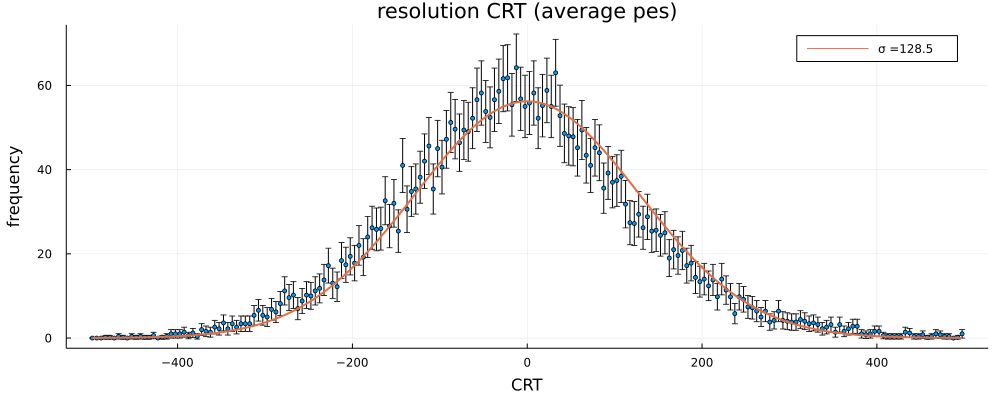

In [84]:
dt = ANema.crt(dfp, ANema.dtaverage,ANema.posrecall)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes)", joinpath(pathp, "CRT-average-recall")) 

## Save

In [83]:
ANema.writemdf(patho,"mdf-phistd-$conf.csv", ndfp)
ANema.writemdf(patho,"mdf-zstd-$conf.csv", ndfz)

"../data/n3mf-w-20mm-phot/mdf-zstd-n3-w-20mm-phot.csv"